In [24]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support

from collections import Counter

from tensorflow import keras
from keras.models import Model
from keras.layers import (
    Input, Embedding, Bidirectional, LSTM,
    Conv1D, GlobalMaxPooling1D, Dense, Dropout, concatenate
)
from keras.optimizers import Adam
from keras.callbacks import Callback

from keras import backend as K 

In [13]:
# -----------------------------
# Step 1: Load & Concatenate Data
# -----------------------------
paths = [
    '../data/goemotions/goemotions_1.csv',
    '../data/goemotions/goemotions_2.csv',
    '../data/goemotions/goemotions_3.csv'
]
# Read and concatenate all parts
dfs = [pd.read_csv(p) for p in paths]
df = pd.concat(dfs, ignore_index=True)

In [14]:
# -----------------------------
# Step 2: Text Cleaning Function
# -----------------------------
def clean_text(text):
    """
    Lowercase, remove HTML tags, strip non-alphanumeric characters,
    and normalize whitespace.
    """
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)            # Remove HTML tags
    text = re.sub(r'[^a-z0-9\s]', '', text)      # Remove punctuation/special chars
    text = re.sub(r'\s+', ' ', text).strip()     # Collapse whitespace
    return text

# Apply cleaning
df['clean_text'] = df['text'].astype(str).apply(clean_text)

In [15]:
# -----------------------------
# Step 3: Train/Val/Test Split
# -----------------------------
# 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.5, random_state=42)

In [16]:
# -----------------------------
# Step 4: Build Vocabulary & Tokenize
# -----------------------------
max_words, max_len = 20_000, 32 # 32 weil 95% der Sequenzen kürzer als 32 sind

counter = Counter()
for t in train_df['clean_text']:
    counter.update(t.split())

vocab = [w for w, _ in counter.most_common(max_words-1)]
word_index = {w: i+2 for i, w in enumerate(vocab)}  # 0=PAD  1=OOV

def text2seq(text):  return [word_index.get(w, 1) for w in text.split()]
def pad(x):          return (x[:max_len] + [0]*max_len)[:max_len]

train_seq = np.array([pad(text2seq(t)) for t in train_df['clean_text']],
                     dtype=np.int16)
val_seq   = np.array([pad(text2seq(t)) for t in val_df['clean_text']],
                     dtype=np.int16)
test_seq  = np.array([pad(text2seq(t)) for t in test_df['clean_text']],
                     dtype=np.int16)

In [17]:
# -----------------------------
# Step 5: Labels
# -----------------------------
exclude = {'text','id','author','subreddit','link_id','parent_id',
           'created_utc','rater_id','example_very_unclear'}
label_cols = [c for c in df.columns
              if c not in exclude and c != 'clean_text']

train_labels = train_df[label_cols].values
val_labels   = val_df[label_cols].values
test_labels  = test_df[label_cols].values

num_classes  = len(label_cols)
vocab_size   = max_words + 2

# -----------------------------
# Step 5.1: Class Weights
# -----------------------------
pos = train_labels.sum(0)
neg = len(train_labels) - pos
class_weight = {i: float(np.clip(neg[i]/pos[i], 1.0, 25.0))
                for i in range(num_classes)}

# <<< optional: kontrolliere die höchsten Gewichte
print("Top-3 class_weight:", sorted(class_weight.items(),
                                    key=lambda kv: kv[1], reverse=True)[:3])

In [18]:
# -----------------------------
# Step 6: Macro-F1 Callback
# -----------------------------
class F1Metrics(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.xv, self.yv = val_data
        self.f1_hist = []

    def on_epoch_end(self, epoch, logs=None):
        p = (self.model.predict(self.xv) > 0.5).astype(int)   # später ggf. opt_thr
        f1 = f1_score(self.yv, p, average='macro')
        self.f1_hist.append(f1)
        print(f" — val_macro_f1: {f1:.4f}")

In [19]:
# -----------------------------
# Step 7: Model Builders
# -----------------------------
def build_lstm_model(vocab_size, max_len, num_classes,
                     emb_dim=100, lstm_units=128):
    inp = Input(shape=(max_len,))
    x   = Embedding(vocab_size, emb_dim)(inp)          # << input_length entfernt
    x   = Bidirectional(LSTM(lstm_units))(x)
    x   = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

def build_cnn_model(vocab_size, max_len, num_classes,
                    emb_dim=100, filters=64, kernel_sizes=[3,4,5]):
    inp = Input(shape=(max_len,))
    x   = Embedding(vocab_size, emb_dim)(inp)          # << input_length entfernt
    convs = []
    for k in kernel_sizes:
        c = Conv1D(filters, k, activation='relu')(x)
        convs.append(GlobalMaxPooling1D()(c))
    x   = concatenate(convs)
    x   = Dropout(0.5)(x)
    out = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model

# -----------------------------
# Callbacks (gemeinsam)
# -----------------------------
common_callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                  min_delta=1e-4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=2, verbose=1, min_lr=1e-6)
]

In [21]:
# -----------------------------
# Step 8: Train Models
# -----------------------------
batch_size, epochs = 32, 20

# —— Bi-LSTM ——
lstm_model = build_lstm_model(vocab_size, max_len, num_classes)
f1_lstm = F1Metrics((val_seq, val_labels))
history_lstm = lstm_model.fit(
    train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=epochs, batch_size=batch_size,
    callbacks=[f1_lstm, *common_callbacks],
    class_weight=class_weight, verbose=2
)

# Speicher freigeben, bevor CNN startet
K.clear_session()

# —— 1D-CNN ——
cnn_model = build_cnn_model(vocab_size, max_len, num_classes)
f1_cnn = F1Metrics((val_seq, val_labels))
history_cnn = cnn_model.fit(
    train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=epochs, batch_size=batch_size,
    callbacks=[f1_cnn, *common_callbacks],
    class_weight=class_weight, verbose=2
)

Epoch 1/20


/Users/leander/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


661/661 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step
 — val_macro_f1: 0.1111
5281/5281 - 437s - 83ms/step - binary_accuracy: 0.9593 - loss: 0.1382 - val_binary_accuracy: 0.9608 - val_loss: 0.1228 - learning_rate: 1.0000e-03
Epoch 2/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step
 — val_macro_f1: 0.1390
5281/5281 - 356s - 67ms/step - binary_accuracy: 0.9610 - loss: 0.1218 - val_binary_accuracy: 0.9613 - val_loss: 0.1191 - learning_rate: 1.0000e-03
Epoch 3/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step
 — val_macro_f1: 0.1614
5281/5281 - 394s - 75ms/step - binary_accuracy: 0.9617 - loss: 0.1166 - val_binary_accuracy: 0.9615 - val_loss: 0.1182 - learning_rate: 1.0000e-03
Epoch 4/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step
 — val_macro_f1: 0.1833
5281/5281 - 418s - 79ms/step - binary_accuracy: 0.9623 - loss: 0.1129 - val_binary_accuracy: 0.9615 - val_loss: 0.1181 - learning_rate: 1.0000e-03
Epoch 5/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step
 — val_macro_f1: 0.1868

Epoch 5: ReduceLROnPlateau reduc

/Users/leander/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 — val_macro_f1: 0.1369
5281/5281 - 989s - 187ms/step - binary_accuracy: 0.9590 - loss: 0.1391 - val_binary_accuracy: 0.9607 - val_loss: 0.1234 - learning_rate: 1.0000e-03
Epoch 2/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
 — val_macro_f1: 0.1571
5281/5281 - 157s - 30ms/step - binary_accuracy: 0.9603 - loss: 0.1265 - val_binary_accuracy: 0.9610 - val_loss: 0.1215 - learning_rate: 1.0000e-03
Epoch 3/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 — val_macro_f1: 0.1732
5281/5281 - 84s - 16ms/step - binary_accuracy: 0.9610 - loss: 0.1222 - val_binary_accuracy: 0.9612 - val_loss: 0.1212 - learning_rate: 1.0000e-03
Epoch 4/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
 — val_macro_f1: 0.1932
5281/5281 - 109s - 21ms/step - binary_accuracy: 0.9614 - loss: 0.1192 - val_binary_accuracy: 0.9609 - val_loss: 0.1214 - learning_rate: 1.0000e-03
Epoch 5/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
 — val_macro_f1: 0.1772

Epoch 5: ReduceLROnPlateau reducing learni

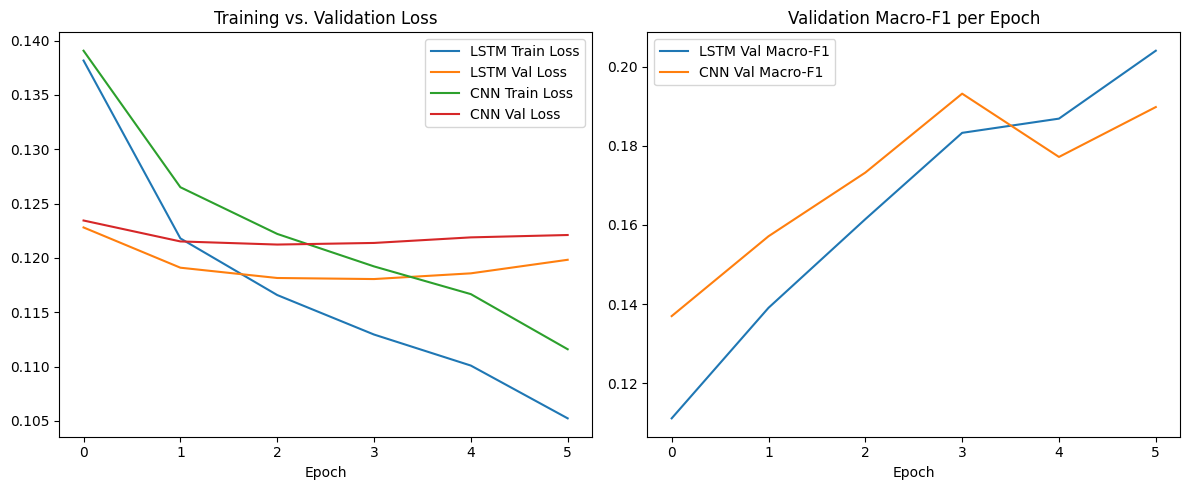

In [ ]:
# -----------------------------
# Step 9: Plots
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_lstm.history['loss'],      label='LSTM Train')
plt.plot(history_lstm.history['val_loss'],  label='LSTM Val')
plt.plot(history_cnn.history['loss'],       label='CNN Train')
plt.plot(history_cnn.history['val_loss'],   label='CNN Val')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(f1_lstm.f1_hist, label='LSTM Macro-F1')
plt.plot(f1_cnn.f1_hist,  label='CNN  Macro-F1')
plt.title('Val Macro-F1'); plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
# -----------------------------
# Step 10: Final Test Evaluation
# -----------------------------
for name, model in [('Bi-LSTM', lstm_model), ('1D-CNN', cnn_model)]:
    # NOTE: Bei Threshold-Tuning hier >= opt_thr[k] einsetzen
    test_pred = (model.predict(test_seq) > 0.5).astype(int)
    macro = f1_score(test_labels, test_pred, average='macro')
    micro = f1_score(test_labels, test_pred, average='micro')
    print(f"\n{name} — Macro-F1: {macro:.4f} | Micro-F1: {micro:.4f}")

661/661 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step

Bi-LSTM — Test Macro-F1: 0.1538, Micro-F1: 0.2856
Sample per-emotion (first 5):
  admiration: P=0.70, R=0.38, F1=0.49
  amusement: P=0.62, R=0.38, F1=0.47
  anger: P=0.53, R=0.11, F1=0.18
  annoyance: P=0.00, R=0.00, F1=0.00
  approval: P=0.70, R=0.04, F1=0.07
661/661 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

1D-CNN — Test Macro-F1: 0.1657, Micro-F1: 0.2683
Sample per-emotion (first 5):
  admiration: P=0.70, R=0.32, F1=0.44
  amusement: P=0.58, R=0.45, F1=0.51
  anger: P=0.54, R=0.06, F1=0.11
  annoyance: P=0.25, R=0.00, F1=0.00
  approval: P=0.69, R=0.03, F1=0.05
